## Project Flow
- Load Dataset
- EDA
- Create Baseline Models
- Feature Engineering, Transformations & Feature Selections
- Cross Validation of Models
- Finalise Dataset
- Model Selection via CV
- HyperParameter Tuning of Selected Model
- Train Tuned Model using Entire new Data
- Save & Deploy Data
- Predict

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)

In [2]:
train = pd.read_csv('train.csv')
train.shape

(614, 13)

In [3]:
test = pd.read_csv('test.csv')
test.shape

test_backup = test.copy()

In [4]:
train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


# Data Validation
since we have categorical features, we would encode that, but need to check if all categories present in testing set are present in training data as well, otherwise we need to handle that separately

In [5]:
categorical_features = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']

for col in categorical_features:
    print('=> ',col)
    print('Train -> ', train[col].unique())
    print('Test  -> ', test[col].unique())
    print('*'*33)

=>  Gender
Train ->  ['Male' 'Female' nan]
Test  ->  ['Male' 'Female' nan]
*********************************
=>  Married
Train ->  ['No' 'Yes' nan]
Test  ->  ['Yes' 'No']
*********************************
=>  Dependents
Train ->  ['0' '1' '2' '3+' nan]
Test  ->  ['0' '1' '2' '3+' nan]
*********************************
=>  Education
Train ->  ['Graduate' 'Not Graduate']
Test  ->  ['Graduate' 'Not Graduate']
*********************************
=>  Self_Employed
Train ->  ['No' 'Yes' nan]
Test  ->  ['No' 'Yes' nan]
*********************************
=>  Property_Area
Train ->  ['Urban' 'Rural' 'Semiurban']
Test  ->  ['Urban' 'Semiurban' 'Rural']
*********************************


> There are no unique categories present in Test set, which are not in Trianing data => Validiated

#### EDA has not been performed yet. Covered in another notebook

## Outliers Detection

### IQR

In [6]:
def IQR(df, col):
    
    # calculate quantiles
    q25, q75 = np.quantile(df[col], 0.25), np.quantile(df[col], 0.75)
    
    # calculate IQR
    iqr = q75 - q25
    
    # defining boundaries
    lower, upper = q25 - (1.5 * iqr), q75 + (1.5 * iqr)
    
    print('IQR is ',iqr)
    print('lower bound is ', lower)
    print('upper bound is ', upper)
    
    # calculate records count beyond range
    df_upper = df[df[col] > upper]
    df_lower = df[df[col] < lower]
    
    print('Total number of outliers are', df_upper.shape[0] + df_lower.shape[0])
    
    # Visualising
    plt.figure(figsize = (10,6))
    sns.distplot(df[col], kde=False)
    plt.axvspan(xmin = lower,xmax= df[col].min(),alpha=0.2, color='red')
    plt.axvspan(xmin = upper,xmax= df[col].max(),alpha=0.2, color='red')

In [7]:
numerical_features = [ 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History' ]

=>  ApplicantIncome
IQR is  2917.5
lower bound is  -1498.75
upper bound is  10171.25
Total number of outliers are 50
*********************************
=>  CoapplicantIncome
IQR is  2297.25
lower bound is  -3445.875
upper bound is  5743.125
Total number of outliers are 18
*********************************
=>  LoanAmount
IQR is  nan
lower bound is  nan
upper bound is  nan
Total number of outliers are 0
*********************************
=>  Loan_Amount_Term
IQR is  nan
lower bound is  nan
upper bound is  nan
Total number of outliers are 0
*********************************
=>  Credit_History
IQR is  nan
lower bound is  nan
upper bound is  nan
Total number of outliers are 0
*********************************


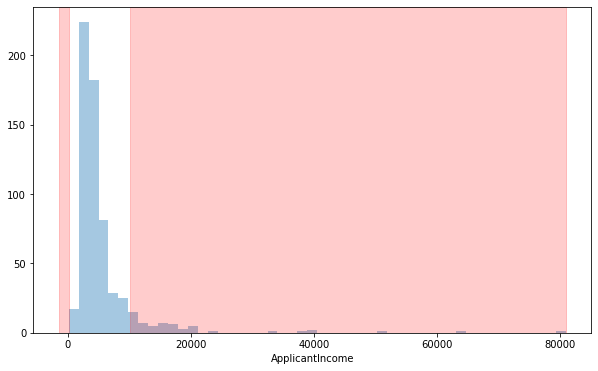

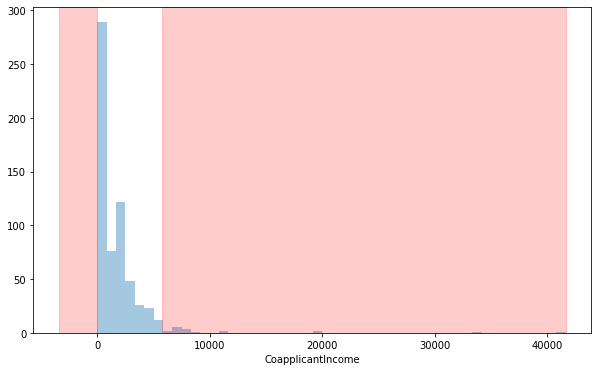

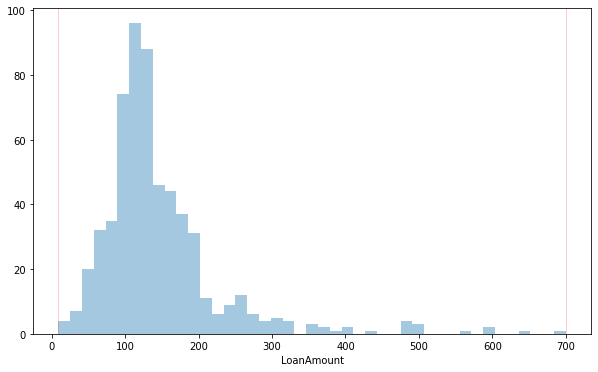

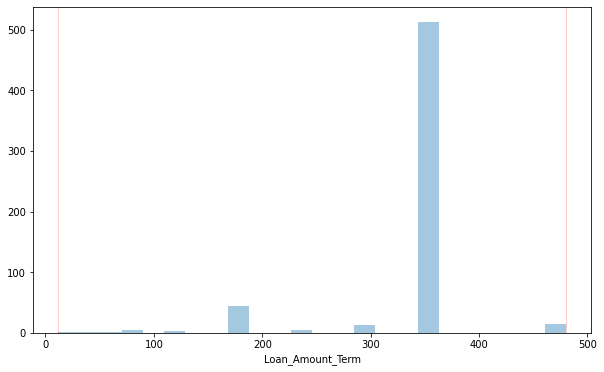

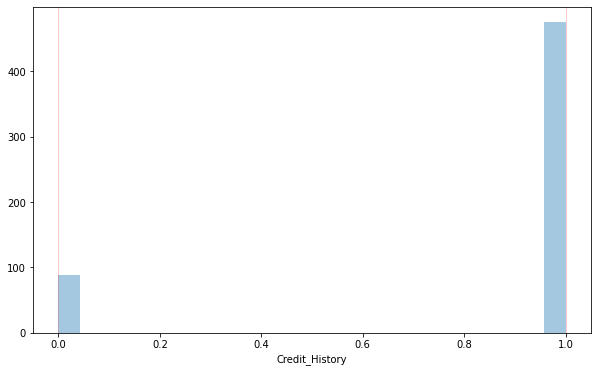

In [8]:
for col in numerical_features:
    print('=> ', col)
    IQR(train, col)
    print('*'*33)

### Z Score

In [9]:
def zscore(col):
    
    outliers = []
    z_scores = []
    threshold = 3
    
    # calculate the mean and standard deviation of the data frame
    data_mean, data_std = col.mean(), col.std()
    
    for i in col:
        z_score = (i - data_mean)/ data_std
        z_scores.append(z_score)
        
        if np.abs(z_score) > threshold:
            outliers.append(i)
            
    print('Total Outliers are ', len(outliers))
    
    # Visualising
    plt.figure(figsize = (10,6))
    sns.distplot(z_scores)
    plt.axvspan(xmin = 3 ,xmax= max(z_scores),alpha=0.2, color='red')

=>  ApplicantIncome
Total Outliers are  8
*********************************
=>  CoapplicantIncome
Total Outliers are  6
*********************************
=>  LoanAmount
Total Outliers are  14
*********************************
=>  Loan_Amount_Term
Total Outliers are  12
*********************************
=>  Credit_History
Total Outliers are  0
*********************************


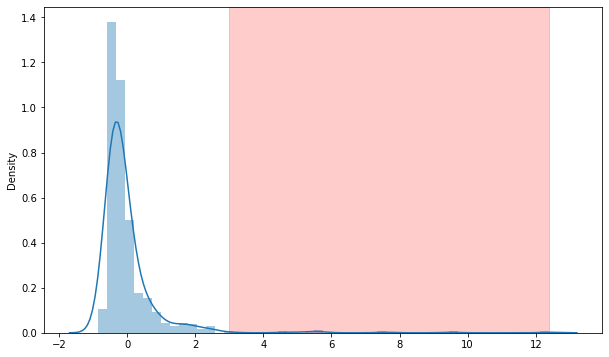

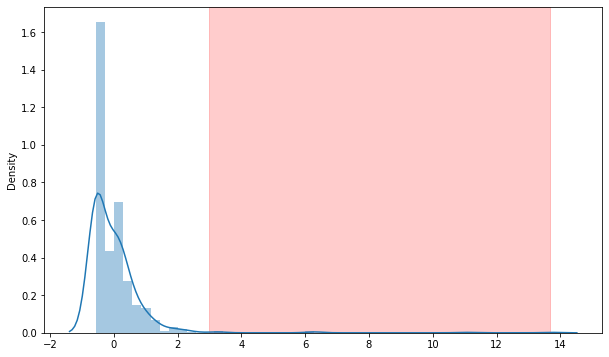

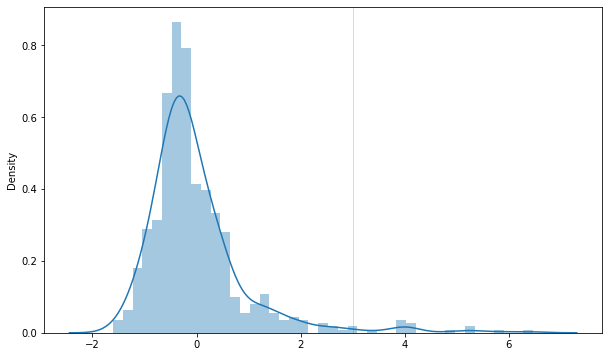

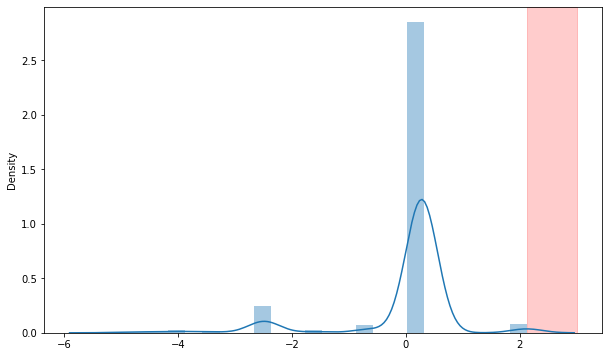

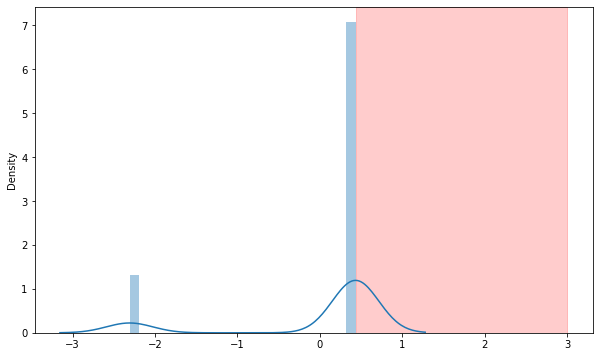

In [10]:
for col in numerical_features:
    print('=> ', col)
    zscore(train[col])
    print('*'*33)

### Standard Deviation

In [11]:
def std(df, col):
    
    # calculate the mean and standard deviation of the data frame
    data_mean, data_std = df[col].mean(), df[col].std()
    
    # initialise the cutoff value
    cut_off = data_std * 3
    
    # calculate the lower and upper bound value
    lower, upper = data_mean - cut_off, data_mean + cut_off
    
    print('The lower bound value is', lower)
    print('The upper bound value is', upper)

    # calculate records count beyond range    
    df_upper = df[df[col] > upper]
    df_lower = df[df[col] < lower]
    
    print('Total number of outliers are', df_upper.shape[0] + df_lower.shape[0])
    
    # Visualising
    plt.figure(figsize = (10,6))
    sns.distplot(df[col], kde=False)
    plt.axvspan(xmin = lower,xmax= df[col].min(),alpha=0.2, color='red')

  
     

=>  ApplicantIncome
The lower bound value is -12923.665736773899
The upper bound value is 23730.584303549145
Total number of outliers are 8
*********************************
=>  CoapplicantIncome
The lower bound value is -7157.499309645475
The upper bound value is 10399.990905699677
Total number of outliers are 6
*********************************
=>  LoanAmount
The lower bound value is -110.34981354495417
The upper bound value is 403.1741378692785
Total number of outliers are 14
*********************************
=>  Loan_Amount_Term
The lower bound value is 146.6387704361623
The upper bound value is 537.3612295638377
Total number of outliers are 12
*********************************
=>  Credit_History
The lower bound value is -0.252436376148931
The upper bound value is 1.9368335392694984
Total number of outliers are 0
*********************************


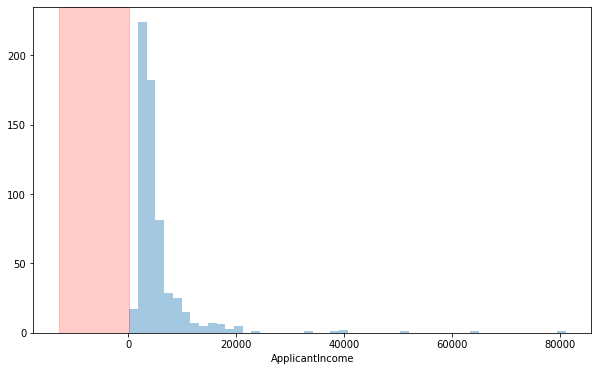

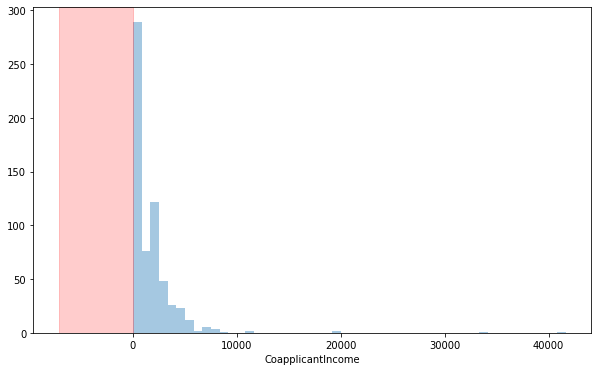

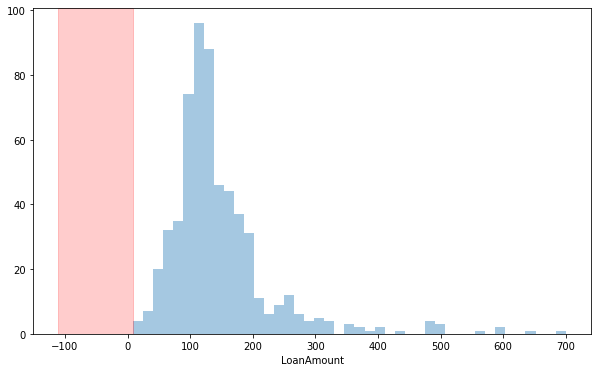

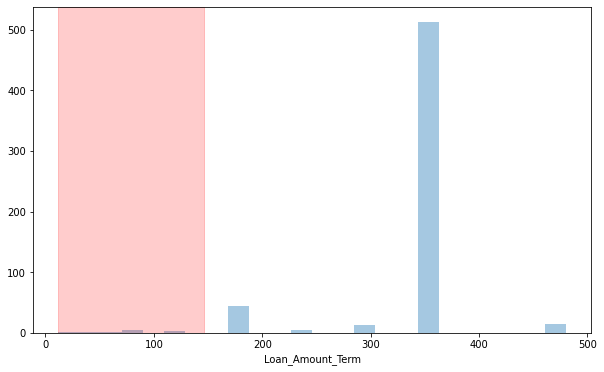

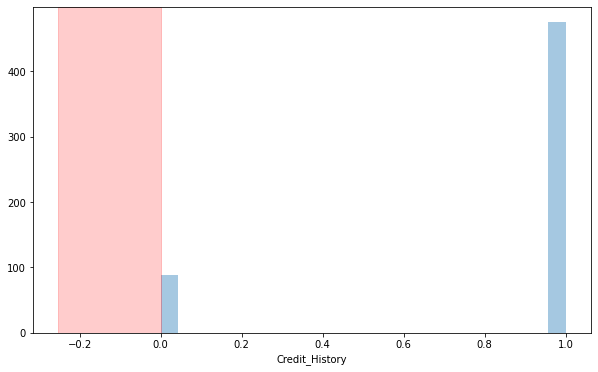

In [12]:
for col in numerical_features:
    print('=> ', col)
    std(train, col)
    print('*'*33)

In [13]:
train.dtypes

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

In [14]:
# Removing outliers from ApplicantIncome considering Standard Deviation
train = train[(train['ApplicantIncome'] < 23730) & (train['ApplicantIncome'] > -12923) ]

In [15]:
# Removing outliers from CoApplicantIncome considering Standard Deviation
train = train[(train['CoapplicantIncome'] < 10399) & (train['CoapplicantIncome'] > -7157) ]

In [16]:
train.shape

(600, 13)

<AxesSubplot: xlabel='LoanAmount', ylabel='Count'>

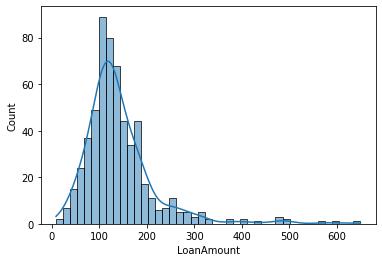

In [17]:
sns.histplot(data= train['LoanAmount'], kde= True)

In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 600 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            600 non-null    object 
 1   Gender             589 non-null    object 
 2   Married            597 non-null    object 
 3   Dependents         585 non-null    object 
 4   Education          600 non-null    object 
 5   Self_Employed      570 non-null    object 
 6   ApplicantIncome    600 non-null    int64  
 7   CoapplicantIncome  600 non-null    float64
 8   LoanAmount         578 non-null    float64
 9   Loan_Amount_Term   586 non-null    float64
 10  Credit_History     551 non-null    float64
 11  Property_Area      600 non-null    object 
 12  Loan_Status        600 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 65.6+ KB


In [19]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            367 non-null    object 
 1   Gender             356 non-null    object 
 2   Married            367 non-null    object 
 3   Dependents         357 non-null    object 
 4   Education          367 non-null    object 
 5   Self_Employed      344 non-null    object 
 6   ApplicantIncome    367 non-null    int64  
 7   CoapplicantIncome  367 non-null    int64  
 8   LoanAmount         362 non-null    float64
 9   Loan_Amount_Term   361 non-null    float64
 10  Credit_History     338 non-null    float64
 11  Property_Area      367 non-null    object 
dtypes: float64(3), int64(2), object(7)
memory usage: 34.5+ KB


In [20]:
train[train.duplicated(keep= 'first')].shape

(0, 13)

In [21]:
train.isnull().sum()

Loan_ID               0
Gender               11
Married               3
Dependents           15
Education             0
Self_Employed        30
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       49
Property_Area         0
Loan_Status           0
dtype: int64

In [22]:
test.isnull().sum()

Loan_ID               0
Gender               11
Married               0
Dependents           10
Education             0
Self_Employed        23
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            5
Loan_Amount_Term      6
Credit_History       29
Property_Area         0
dtype: int64

# Splitting Train data into Train & Val

In [23]:
from sklearn.model_selection import train_test_split

X = train.drop(['Loan_Status'], axis= 1)
y = train['Loan_Status']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=9, stratify= y)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((480, 12), (120, 12), (480,), (120,))

In [24]:
X_train['Gender'].value_counts(normalize= True)

Male      0.817021
Female    0.182979
Name: Gender, dtype: float64

### Why this is important : Suppse `if one of the values were dominant (covering > 80% suppose), then we could have used that value to impute in these missing values`

#### if suppose both were too close, and if we assign there missing values to a particular class (using MODE) , then the `distribution will significantly change`, in that case we need to think other way around


# check column transformer to do all tasks together

In [25]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder

In [26]:
Imputer = ColumnTransformer(transformers = [
    ('mode', SimpleImputer(strategy= 'most_frequent'), ['Gender', 'Married', 'Dependents', 'Self_Employed', 'Loan_Amount_Term', 'Credit_History']),
    ('mean', SimpleImputer(strategy= 'mean'), ['LoanAmount'])
], remainder= 'drop')

In [27]:
Imputed_data_train = Imputer.fit_transform(X_train)
Imputed_data_train

array([['Male', 'Yes', '2', ..., 360.0, 1.0, 155.0],
       ['Male', 'No', '0', ..., 360.0, 1.0, 311.0],
       ['Male', 'Yes', '0', ..., 180.0, 0.0, 90.0],
       ...,
       ['Male', 'No', '0', ..., 360.0, 1.0, 144.1459694989107],
       ['Female', 'No', '1', ..., 360.0, 1.0, 144.1459694989107],
       ['Male', 'Yes', '0', ..., 360.0, 1.0, 144.1459694989107]],
      dtype=object)

In [28]:
Imputer.named_transformers_['mode'].get_feature_names_out()

array(['Gender', 'Married', 'Dependents', 'Self_Employed',
       'Loan_Amount_Term', 'Credit_History'], dtype=object)

In [29]:
Imputer.named_transformers_['mean'].get_feature_names_out()

array(['LoanAmount'], dtype=object)

In [30]:
new_cols = Imputer.get_feature_names_out()
new_cols

array(['mode__Gender', 'mode__Married', 'mode__Dependents',
       'mode__Self_Employed', 'mode__Loan_Amount_Term',
       'mode__Credit_History', 'mean__LoanAmount'], dtype=object)

In [31]:
Imputed_df_train = pd.DataFrame(Imputed_data_train, columns=new_cols)
Imputed_df_train.tail()

,mode__Gender,mode__Married,mode__Dependents,mode__Self_Employed,mode__Loan_Amount_Term,mode__Credit_History,mean__LoanAmount
475,Male,Yes,0,No,360.0,1.0,129.0
476,Male,Yes,2,No,360.0,0.0,258.0
477,Male,No,0,No,360.0,1.0,144.145969
478,Female,No,1,Yes,360.0,1.0,144.145969
479,Male,Yes,0,No,360.0,1.0,144.145969


In [32]:
Imputed_df_train.isnull().sum()

mode__Gender              0
mode__Married             0
mode__Dependents          0
mode__Self_Employed       0
mode__Loan_Amount_Term    0
mode__Credit_History      0
mean__LoanAmount          0
dtype: int64

In [33]:
Imputed_df_train.shape

(480, 7)

In [34]:
X_train = X_train.reset_index(drop= True)
Imputed_df_train = Imputed_df_train.reset_index(drop=True)

X_train = pd.concat([X_train, Imputed_df_train], axis=1)
X_train.tail()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,mode__Gender,mode__Married,mode__Dependents,mode__Self_Employed,mode__Loan_Amount_Term,mode__Credit_History,mean__LoanAmount
475,LP001578,Male,Yes,0,Graduate,No,2439,3333.0,129.0,360.0,1.0,Rural,Male,Yes,0,No,360.0,1.0,129.0
476,LP002832,Male,Yes,2,Graduate,No,8799,0.0,258.0,360.0,0.0,Urban,Male,Yes,2,No,360.0,0.0,258.0
477,LP002697,Male,No,0,Graduate,No,4680,2087.0,NaN,360.0,1.0,Semiurban,Male,No,0,No,360.0,1.0,144.145969
478,LP001392,Female,No,1,Graduate,Yes,7451,0.0,NaN,360.0,1.0,Semiurban,Female,No,1,Yes,360.0,1.0,144.145969
479,LP001356,Male,Yes,0,Graduate,No,4652,3583.0,NaN,360.0,1.0,Semiurban,Male,Yes,0,No,360.0,1.0,144.145969


In [35]:
X_train.isnull().sum()

Loan_ID                    0
Gender                    10
Married                    3
Dependents                14
Education                  0
Self_Employed             22
ApplicantIncome            0
CoapplicantIncome          0
LoanAmount                21
Loan_Amount_Term          11
Credit_History            40
Property_Area              0
mode__Gender               0
mode__Married              0
mode__Dependents           0
mode__Self_Employed        0
mode__Loan_Amount_Term     0
mode__Credit_History       0
mean__LoanAmount           0
dtype: int64

# One Hot Encoding

In [36]:
encoder = ColumnTransformer(transformers = [
    ('encOH', OneHotEncoder(sparse= False, drop= 'first'), ['mode__Gender', 'mode__Married', 'mode__Dependents', 'mode__Self_Employed', 'Property_Area' ]),
    ('encOR', OrdinalEncoder(categories =[[ 'Not Graduate', 'Graduate']]), ['Education'])
], remainder= 'drop')

In [37]:
encoded_data_train = encoder.fit_transform(X_train)
encoded_data_train

array([[1., 1., 0., ..., 1., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 1., 0., ..., 0., 0., 1.],
       ...,
       [1., 0., 0., ..., 1., 0., 1.],
       [0., 0., 1., ..., 1., 0., 1.],
       [1., 1., 0., ..., 1., 0., 1.]])

In [38]:
encoder.named_transformers_['encOH'].get_feature_names_out()

array(['mode__Gender_Male', 'mode__Married_Yes', 'mode__Dependents_1',
       'mode__Dependents_2', 'mode__Dependents_3+',
       'mode__Self_Employed_Yes', 'Property_Area_Semiurban',
       'Property_Area_Urban'], dtype=object)

In [39]:
new_cols = encoder.get_feature_names_out()
new_cols

array(['encOH__mode__Gender_Male', 'encOH__mode__Married_Yes',
       'encOH__mode__Dependents_1', 'encOH__mode__Dependents_2',
       'encOH__mode__Dependents_3+', 'encOH__mode__Self_Employed_Yes',
       'encOH__Property_Area_Semiurban', 'encOH__Property_Area_Urban',
       'encOR__Education'], dtype=object)

In [40]:
encoded_df_train = pd.DataFrame(encoded_data_train, columns=new_cols, dtype= int)
encoded_df_train.head()

,encOH__mode__Gender_Male,encOH__mode__Married_Yes,encOH__mode__Dependents_1,encOH__mode__Dependents_2,encOH__mode__Dependents_3+,encOH__mode__Self_Employed_Yes,encOH__Property_Area_Semiurban,encOH__Property_Area_Urban,encOR__Education
0,1,1,0,1,0,0,1,0,1
1,1,0,0,0,0,0,0,0,1
2,1,1,0,0,0,0,0,0,1
3,1,0,0,0,0,1,0,0,1
4,1,1,0,0,0,0,0,0,1


In [41]:
X_train = X_train.reset_index(drop= True)
encoded_df_train = encoded_df_train.reset_index(drop=True)

X_train = pd.concat([X_train, encoded_df_train], axis=1)
X_train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,mode__Gender,mode__Married,mode__Dependents,mode__Self_Employed,mode__Loan_Amount_Term,mode__Credit_History,mean__LoanAmount,encOH__mode__Gender_Male,encOH__mode__Married_Yes,encOH__mode__Dependents_1,encOH__mode__Dependents_2,encOH__mode__Dependents_3+,encOH__mode__Self_Employed_Yes,encOH__Property_Area_Semiurban,encOH__Property_Area_Urban,encOR__Education
0,LP002197,Male,Yes,2,Graduate,No,5185,0.0,155.0,360.0,1.0,Semiurban,Male,Yes,2,No,360.0,1.0,155.0,1,1,0,1,0,0,1,0,1
1,LP002652,Male,No,0,Graduate,No,5815,3666.0,311.0,360.0,1.0,Rural,Male,No,0,No,360.0,1.0,311.0,1,0,0,0,0,0,0,0,1
2,LP002449,Male,Yes,0,Graduate,No,2483,2466.0,90.0,180.0,0.0,Rural,Male,Yes,0,No,180.0,0.0,90.0,1,1,0,0,0,0,0,0,1
3,LP001761,Male,No,0,Graduate,Yes,6400,0.0,200.0,360.0,1.0,Rural,Male,No,0,Yes,360.0,1.0,200.0,1,0,0,0,0,1,0,0,1
4,LP001926,Male,Yes,0,Graduate,No,3704,2000.0,120.0,360.0,1.0,Rural,Male,Yes,0,No,360.0,1.0,120.0,1,1,0,0,0,0,0,0,1


In [42]:
X_train.isnull().sum()

Loan_ID                            0
Gender                            10
Married                            3
Dependents                        14
Education                          0
Self_Employed                     22
ApplicantIncome                    0
CoapplicantIncome                  0
LoanAmount                        21
Loan_Amount_Term                  11
Credit_History                    40
Property_Area                      0
mode__Gender                       0
mode__Married                      0
mode__Dependents                   0
mode__Self_Employed                0
mode__Loan_Amount_Term             0
mode__Credit_History               0
mean__LoanAmount                   0
encOH__mode__Gender_Male           0
encOH__mode__Married_Yes           0
encOH__mode__Dependents_1          0
encOH__mode__Dependents_2          0
encOH__mode__Dependents_3+         0
encOH__mode__Self_Employed_Yes     0
encOH__Property_Area_Semiurban     0
encOH__Property_Area_Urban         0
e

# Imputing & Encoding Validation & Test Dataset

#### Imputing Val

In [43]:
Imputed_data_val = Imputer.transform(X_val)
new_cols = Imputer.get_feature_names_out()
Imputed_df_val = pd.DataFrame(Imputed_data_val, columns=new_cols)

X_val = X_val.reset_index(drop= True)
Imputed_df_val = Imputed_df_val.reset_index(drop=True)

X_val = pd.concat([X_val, Imputed_df_val], axis=1)

#### Encoding Val

In [44]:
encoded_data_val = encoder.transform(X_val)
new_cols = encoder.get_feature_names_out()
encoded_df_val = pd.DataFrame(encoded_data_val, columns=new_cols, dtype= int)

X_val = X_val.reset_index(drop= True)
encoded_df_val = encoded_df_val.reset_index(drop=True)

X_val = pd.concat([X_val, encoded_df_val], axis=1)

#### Imputing Test

In [45]:
Imputed_data_test = Imputer.transform(test)
new_cols = Imputer.get_feature_names_out()
Imputed_df_test = pd.DataFrame(Imputed_data_test, columns=new_cols)

test = test.reset_index(drop= True)
Imputed_df_test = Imputed_df_test.reset_index(drop=True)

test = pd.concat([test, Imputed_df_test], axis=1)

#### Encoding Test

In [46]:
encoded_data_test = encoder.transform(test)
new_cols = encoder.get_feature_names_out()
encoded_df_test = pd.DataFrame(encoded_data_test, columns=new_cols, dtype= int)

test = test.reset_index(drop= True)
encoded_df_test = encoded_df_test.reset_index(drop=True)

test = pd.concat([test, encoded_df_test], axis=1)

## Dropping Index Identifier : loan_id

In [47]:
X_train.drop(['Loan_ID'], axis= 1, inplace= True)
X_val.drop(['Loan_ID'], axis= 1, inplace= True)
test.drop(['Loan_ID'], axis= 1, inplace= True)

## Validating Data Types of Features

In [48]:
# Train
X_train['mode__Loan_Amount_Term'] = X_train['mode__Loan_Amount_Term'].astype('int')
X_train['mode__Credit_History'] = X_train['mode__Credit_History'].astype('int')
X_train['mean__LoanAmount'] = X_train['mean__LoanAmount'].astype('float')

# Test
X_val['mode__Loan_Amount_Term'] = X_val['mode__Loan_Amount_Term'].astype('int')
X_val['mode__Credit_History'] = X_val['mode__Credit_History'].astype('int')
X_val['mean__LoanAmount'] = X_val['mean__LoanAmount'].astype('float')

# Val
test['mode__Loan_Amount_Term'] = test['mode__Loan_Amount_Term'].astype('int')
test['mode__Credit_History'] = test['mode__Credit_History'].astype('int')
test['mean__LoanAmount'] = test['mean__LoanAmount'].astype('float')

## Separating Numerical Features for Further Analysis

In [49]:
numerical_features = [ 'ApplicantIncome', 'CoapplicantIncome', 'mean__LoanAmount', 'mode__Loan_Amount_Term', 'mode__Credit_History' ]

## Detecting `Multi-Collinearity`

In [50]:
X_train[numerical_features].corr().round(2)

,ApplicantIncome,CoapplicantIncome,mean__LoanAmount,mode__Loan_Amount_Term,mode__Credit_History
ApplicantIncome,1.00,-0.16,0.62,0.02,0.06
CoapplicantIncome,-0.16,1.00,0.25,-0.06,-0.03
mean__LoanAmount,0.62,0.25,1.00,0.11,0.05
mode__Loan_Amount_Term,0.02,-0.06,0.11,1.00,-0.00
mode__Credit_History,0.06,-0.03,0.05,-0.00,1.00


<AxesSubplot: >

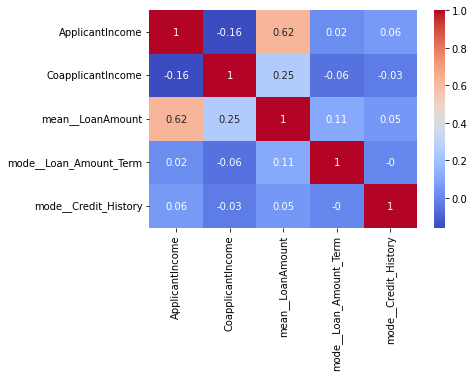

In [51]:
sns.heatmap(X_train[numerical_features].corr().round(2), annot= True, cmap='coolwarm')

#### Quick Statistical Summary of Data

In [52]:
X_train[numerical_features].describe().round(2)

,ApplicantIncome,CoapplicantIncome,mean__LoanAmount,mode__Loan_Amount_Term,mode__Credit_History
count,480.00,480.00,480.00,480.00,480.00
mean,5008.53,1441.32,144.15,342.00,0.86
std,3555.31,1723.58,77.87,66.39,0.35
min,150.00,0.00,9.00,12.00,0.00
25%,2912.75,0.00,100.75,360.00,1.00
50%,3807.00,1128.50,129.50,360.00,1.00
75%,5818.25,2259.25,165.00,360.00,1.00
max,20833.00,8980.00,650.00,480.00,1.00


- verify the minimum values of feature, if they are negative.
- verify if max values of features make sense and are logical
- verify if it contains outliers, an idea could be generated by looking min, max & Mean

## Building Base Model

In [53]:
final_processed_features = [ 'encOH__mode__Gender_Male', 'encOH__mode__Married_Yes',
       'encOH__mode__Dependents_1', 'encOH__mode__Dependents_2',
       'encOH__mode__Dependents_3+', 'encOH__mode__Self_Employed_Yes',
       'encOH__Property_Area_Semiurban', 'encOH__Property_Area_Urban',
       'encOR__Education' , 'mode__Loan_Amount_Term', 'mode__Credit_History', 'mean__LoanAmount'  ]

In [54]:
### Let's try out a few more models

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
 
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier


In [55]:
models = []

models.append(('LR', LogisticRegression(class_weight='balanced', random_state=9)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier(random_state=9)))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC( random_state=9)))
models.append(('RF', RandomForestClassifier(random_state=9)))
models.append(('GB', GradientBoostingClassifier(random_state=9)))
models.append(('AdaB', AdaBoostClassifier(random_state=9)))

models

[('LR', LogisticRegression(class_weight='balanced', random_state=9)),
 ('LDA', LinearDiscriminantAnalysis()),
 ('KNN', KNeighborsClassifier()),
 ('CART', DecisionTreeClassifier(random_state=9)),
 ('NB', GaussianNB()),
 ('SVM', SVC(random_state=9)),
 ('RF', RandomForestClassifier(random_state=9)),
 ('GB', GradientBoostingClassifier(random_state=9)),
 ('AdaB', AdaBoostClassifier(random_state=9))]

In [56]:
train_base_scores = []
val_base_scores = []
model_names = []

for name, model in models:
    model.fit(X_train[final_processed_features], y_train)
    model_names.append(name)
    train_base_scores.append(model.score(X_train[final_processed_features], y_train ))
    val_base_scores.append(model.score(X_val[final_processed_features], y_val ))

In [57]:
for model, train_score, val_score in zip(model_names, train_base_scores, val_base_scores):
    print('Model -> ', model)
    print('Train Score -> ', round(train_score,2))
    print('Val Score -> ', round(val_score,2))
    print('*'*30)

Model ->  LR
Train Score ->  0.77
Val Score ->  0.78
******************************
Model ->  LDA
Train Score ->  0.82
Val Score ->  0.8
******************************
Model ->  KNN
Train Score ->  0.73
Val Score ->  0.69
******************************
Model ->  CART
Train Score ->  0.99
Val Score ->  0.73
******************************
Model ->  NB
Train Score ->  0.82
Val Score ->  0.79
******************************
Model ->  SVM
Train Score ->  0.69
Val Score ->  0.69
******************************
Model ->  RF
Train Score ->  0.99
Val Score ->  0.73
******************************
Model ->  GB
Train Score ->  0.88
Val Score ->  0.79
******************************
Model ->  AdaB
Train Score ->  0.84
Val Score ->  0.78
******************************


In [58]:
y_train.value_counts(normalize=True)

Y    0.691667
N    0.308333
Name: Loan_Status, dtype: float64

In [59]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

results = []
model_names = []
n_splits= 5

for name, model in models:
    kfold = StratifiedKFold(n_splits= 5, shuffle= True, random_state= 9)
    cv_results = cross_val_score(model, X_train[final_processed_features], y_train, cv= kfold)
    results.append(cv_results)
    model_names.append(name)
    
    msg = "%s: %5.2f (%5.2f)" % (name, cv_results.mean()*100, cv_results.std()*100)
    print(msg)
    
results_df = pd.DataFrame(results, index = model_names, columns = 'CV1 CV2 CV3 CV4 CV5'.split())
results_df['CV Mean'] = results_df.iloc[:, 0:n_splits].mean(axis=1)
results_df['CV Std Dev'] = results_df.iloc[:, 0:n_splits].std(axis=1)
results_df.sort_values(by= 'CV Mean', ascending= False)*100


    

LR: 75.83 ( 2.02)
LDA: 81.88 ( 1.06)
KNN: 60.42 ( 1.98)
CART: 69.79 ( 5.02)
NB: 81.04 ( 0.78)
SVM: 69.17 ( 0.51)
RF: 79.38 ( 2.83)
GB: 77.08 ( 2.95)
AdaB: 78.96 ( 1.21)


,CV1,CV2,CV3,CV4,CV5,CV Mean,CV Std Dev
LDA,83.333333,80.208333,82.291667,81.250000,82.291667,81.875000,1.187683
NB,82.291667,80.208333,81.250000,80.208333,81.250000,81.041667,0.871521
RF,84.375000,78.125000,80.208333,78.125000,76.041667,79.375000,3.159531
AdaB,78.125000,78.125000,81.250000,79.166667,78.125000,78.958333,1.358167
GB,78.125000,71.875000,80.208333,79.166667,76.041667,77.083333,3.294039
LR,72.916667,77.083333,78.125000,77.083333,73.958333,75.833333,2.258280
CART,62.500000,72.916667,69.791667,77.083333,66.666667,69.791667,5.609547
SVM,69.791667,69.791667,68.750000,68.750000,68.750000,69.166667,0.570544
KNN,60.416667,63.541667,60.416667,60.416667,57.291667,60.416667,2.209709


## Scaling Features

In [60]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [61]:
cols_to_scale = ['mode__Loan_Amount_Term', 'mean__LoanAmount']

In [62]:
scaler.fit(X_train[cols_to_scale])

StandardScaler()

In [63]:
X_train[cols_to_scale] = scaler.transform(X_train[cols_to_scale])
X_val[cols_to_scale] = scaler.transform(X_val[cols_to_scale])
test[cols_to_scale] = scaler.transform(test[cols_to_scale])

## Re Training & Evaluating Models

In [64]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

results = []
model_names = []
n_splits= 5

for name, model in models:
    kfold = StratifiedKFold(n_splits= 5, shuffle= True, random_state= 9)
    cv_results = cross_val_score(model, X_train[final_processed_features], y_train, cv= kfold)
    results.append(cv_results)
    model_names.append(name)
    
    msg = "%s: %5.2f (%5.2f)" % (name, cv_results.mean()*100, cv_results.std()*100)
    print(msg)
    
results_df = pd.DataFrame(results, index = model_names, columns = 'CV1 CV2 CV3 CV4 CV5'.split())
results_df['CV Mean'] = results_df.iloc[:, 0:n_splits].mean(axis=1)
results_df['CV Std Dev'] = results_df.iloc[:, 0:n_splits].std(axis=1)
results_df.sort_values(by= 'CV Mean', ascending= False)*100


    

LR: 76.04 ( 2.47)
LDA: 81.88 ( 1.06)
KNN: 74.17 ( 2.83)
CART: 69.79 ( 5.02)
NB: 81.04 ( 0.78)
SVM: 81.04 ( 2.02)
RF: 79.38 ( 2.83)
GB: 77.29 ( 2.59)
AdaB: 79.17 ( 1.14)


,CV1,CV2,CV3,CV4,CV5,CV Mean,CV Std Dev
LDA,83.333333,80.208333,82.291667,81.250000,82.291667,81.875000,1.187683
NB,82.291667,80.208333,81.250000,80.208333,81.250000,81.041667,0.871521
SVM,83.333333,80.208333,83.333333,80.208333,78.125000,81.041667,2.258280
RF,84.375000,78.125000,80.208333,78.125000,76.041667,79.375000,3.159531
AdaB,78.125000,79.166667,81.250000,79.166667,78.125000,79.166667,1.275776
GB,78.125000,72.916667,80.208333,79.166667,76.041667,77.291667,2.890508
LR,71.875000,79.166667,77.083333,77.083333,75.000000,76.041667,2.755991
KNN,71.875000,77.083333,76.041667,76.041667,69.791667,74.166667,3.159531
CART,62.500000,72.916667,69.791667,77.083333,66.666667,69.791667,5.609547


In [65]:
from sklearn.model_selection import GridSearchCV

clf = GaussianNB()

# define parameter grid for grid search
param_grid = {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]}

In [66]:
# perform grid search using 5-fold cross-validation
grid_search = GridSearchCV(clf, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train[final_processed_features], y_train)

# print the best parameters and corresponding accuracy score
print("Best parameters: ", grid_search.best_params_)
print("Best accuracy score: ", grid_search.best_score_)

Best parameters:  {'var_smoothing': 1e-09}
Best accuracy score:  0.7979166666666667


In [67]:
clf = GaussianNB(var_smoothing= 1e-09)

## Training Final Model

In [68]:
clf.fit(X_train[final_processed_features], y_train)

GaussianNB()

In [69]:
# Trianing Score
clf.score(X_train[final_processed_features], y_train)

0.8166666666666667

In [70]:
# Validation Score
clf.score(X_val[final_processed_features], y_val)

0.7916666666666666

In [71]:
#checking predictions son Validation set
pred_test = clf.predict(test[final_processed_features])
pred_test

array(['Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'N',
       'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'N',
       'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'Y',
       'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y',
       'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'N', 'N',
       'Y', 'N', 'N', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y',
       'Y', 'Y', 'N', 'Y', 'N', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y',
       'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'Y',
       'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y',
       'N', 'N', 'N', 'Y', 'Y', 'Y', 'N', 'N', 'Y', 'N', 'Y', 'Y', 'Y',
       'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'N',
       'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'Y',
       'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'N', 'N', 'Y', 'N',
       'Y', 'Y', 'Y', 'Y', 'N', 'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y

In [72]:
pred_test_df = pd.DataFrame({'Loan_ID' : test_backup['Loan_ID'], 'Loan_Status' : pred_test})
pred_test_df.head()

,Loan_ID,Loan_Status
0,LP001015,Y
1,LP001022,Y
2,LP001031,Y
3,LP001035,Y
4,LP001051,Y


In [73]:
# saving File
pred_test_df.to_csv("predicted_Loan_Defaulter.csv", index=False)

## Trying Lazy Predictor

In [77]:
import lazypredict
from lazypredict.Supervised import LazyClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

In [79]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train[final_processed_features], X_val[final_processed_features], y_train, y_val)
models

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 25.33it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
AdaBoostClassifier,0.78,0.71,None,0.77,0.13
LGBMClassifier,0.78,0.70,None,0.77,0.14
BernoulliNB,0.80,0.69,None,0.77,0.02
LinearDiscriminantAnalysis,0.80,0.69,None,0.77,0.01
RidgeClassifierCV,0.80,0.69,None,0.77,0.02
RidgeClassifier,0.80,0.69,None,0.77,0.02
NuSVC,0.80,0.69,None,0.77,0.02
CalibratedClassifierCV,0.80,0.69,None,0.77,0.11
LogisticRegression,0.80,0.69,None,0.77,0.02
